# SEE Filtering

## Python script that filters SEE = 0 from ECLASS-public dataset. 

_Requires eclass-public repo from https://github.com/Lewandowski-Labs-PER/eclass-public. Either download manually or git clone: https://github.com/Lewandowski-Labs-PER/eclass-public.git._

## Importing modules

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
# Requires data-helper file to be saved in the same location as own analysis file
dh = importlib.import_module("eclass-public.DataHelper")


## Reading data

In [23]:
data = dh.eclass_data(route='eclass-public/')

# We are only interested in matched data

df = data.get_matched(unique_students=True).reset_index(
    drop=True)  # Matched responses of all students
# Matched responses of students in their first year/introductory courses
df_intro = data.get_intro_matched(unique_students=True).reset_index(drop=True)
df_buffy = data.get_buffy_matched(unique_students=True).reset_index(
    drop=True)  # Matched responses of students in beyond first year courses


/Users/taylo/Documents/ICL/Year 1/Projects/UROP/SEE/eclass-public/DataHelper.py:24: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.cis['StartDate'] = pd.to_datetime(self.cis['StartDate'])


## Grouping by student

In [24]:
# %%Creating a column that identifies whether a student was in an Intro (1) or BUFFY (2) course

ids = np.array(df['anon_student_id'])  # ids for all students
intro_ids = np.array(df_intro['anon_student_id'])
buffy_ids = np.array(df_buffy['anon_student_id'])
course_ids = np.array(df['survey_id_pre'])
buffy_course_ids = np.array(df_buffy['survey_id_pre'])
intro_course_ids = np.array(df_intro['survey_id_pre'])


for i in range(0, len(ids)):
    if (df.anon_student_id[i] in intro_ids) and (df.survey_id_pre[i] in intro_course_ids) == True:
        df.loc[df.index[i], 'CourseType'] = 1
    elif (df.anon_student_id[i] in buffy_ids) == True:
        df.loc[df.index[i], 'CourseType'] = 2

print(df.groupby('CourseType').anon_student_id.count())

CourseType
1.0    17749
2.0     2868
Name: anon_student_id, dtype: int64


## Obtaining IDs, calculating delta, shifting likert points scale

In [25]:

# First we obtain the question ids for each item, we'll use these to calculate each students E-CLASS & Delta score
preids = [x[:-1]
          for i, x in enumerate(data.pre_survey_question_ids) if i % 2 < 1]
a_pre = []
b_pre = []
a_post = []
b_post = []
for id in preids:
    a_pre.append(id + "a_pre")
    b_pre.append(id + "b_pre")
    a_post.append(id + "a_post")
    b_post.append(id + "b_post")
columns = a_pre+b_pre+a_post+b_post
columns.sort()

# Calculate delta scores using original 5-pt score
delta_ids = []
delta_ids_post = []
for id in preids:
    df["delta_pre"+id] = (df[id+"a_pre"] - df[id+"b_pre"])
    df["delta_post"+id] = (df[id+"a_post"] - df[id+"b_post"])
    delta_ids.append("delta_pre"+id)
    delta_ids_post.append("delta_post"+id)

# Converting data from 5-pt scale to 3-pt scale
df[columns] = df[columns].replace({5: 2, 4: 1, 3: 0, 2: -1, 1: -2})
df[columns] = df[columns].replace({2: 1, -2: -1})

for id in preids:
    # Calculates YOU item difference between pre and post score
    df["a_diff"+id] = (-df[id+"a_pre"] + df[id+"a_post"])
    # Calculates pre item difference between pre and post score
    df["b_diff"+id] = (-df[id+"b_pre"] + df[id+"b_post"])

delta_columns = delta_ids+delta_ids_post
df[delta_columns] = df[delta_columns]

delta_columns = delta_columns+["Q54"]
delta_columns = delta_columns[:-1]

df['pre_delta_sum'] = df[delta_ids].apply(
    lambda x: x).sum(axis=1)  # Summing delta scores
df['post_delta_sum'] = df[delta_ids_post].apply(lambda x: x).sum(axis=1)

/var/folders/34/pdmn0l9x56s360wd6f570p5w0000gn/T/ipykernel_67448/1525517177.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["a_diff"+id] = (-df[id+"a_pre"] + df[id+"a_post"])
/var/folders/34/pdmn0l9x56s360wd6f570p5w0000gn/T/ipykernel_67448/1525517177.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["b_diff"+id] = (-df[id+"b_pre"] + df[id+"b_post"])
/var/folders/34/pdmn0l9x56s360wd6f570p5w0000gn/T/ipykernel_67448/1525517177.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [26]:
df_processed=df.copy()
df_processed[delta_ids] = df[delta_ids]
df_processed[delta_ids_post] = df[delta_ids_post]
df_processed[columns] = df[columns]

df_processed = df_processed.fillna(0) #Entries with "NA" replaced with 0

In [27]:
#%%
df_delta_pre = df_processed[delta_ids]
df_delta_post = df_processed[delta_ids_post]

delta_tf_pre = df_delta_pre.eq(df_delta_pre.iloc[:, 0], axis=0).all(axis=1)
df_processed["DeltaEqualPre"] = delta_tf_pre
df_processed["DeltaEqualPre"] = df_processed["DeltaEqualPre"].replace(
    {False: 0, True: 1})  # 1 is Valid, 0 is Invalid

delta_tf_post = df_delta_post.eq(df_delta_post.iloc[:, 0], axis=0).all(axis=1)
df_processed["DeltaEqualPost"] = delta_tf_post
df_processed["DeltaEqualPost"] = df_processed["DeltaEqualPost"].replace({
                                                                        False: 0, True: 1})

for i in range(0, len(df_processed)):
    if (df_processed.DeltaEqualPre[i] == 1) and (df_processed.pre_delta_sum[i] == 0):
        df_processed.loc[df_processed.index[i], 'DeltaValidityPre'] = 1
    else:
        df_processed.loc[df_processed.index[i], 'DeltaValidityPre'] = 0

for i in range(0, len(df_processed)):
    if (df_processed.DeltaEqualPost[i] == 1) and (df_processed.post_delta_sum[i] == 0):
        df_processed.loc[df_processed.index[i], 'DeltaValidityPost'] = 1
    else:
        df_processed.loc[df_processed.index[i], 'DeltaValidityPost'] = 0

for i in range(0, len(ids)):  # filters through union of invalid students
    if (df_processed.DeltaValidityPre[i] == 1) or (df_processed.DeltaValidityPost[i] == 1):
        df_processed.loc[df_processed.index[i], 'DeltaValidity'] = 1
    else:
        df_processed.loc[df_processed.index[i], 'DeltaValidity'] = 0
# Selects just valid students
df_processed = df_processed[df_processed["DeltaValidity"] == 0]


/var/folders/34/pdmn0l9x56s360wd6f570p5w0000gn/T/ipykernel_67448/3695497147.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_processed["DeltaEqualPre"] = delta_tf_pre
/var/folders/34/pdmn0l9x56s360wd6f570p5w0000gn/T/ipykernel_67448/3695497147.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_processed["DeltaEqualPost"] = delta_tf_post
/var/folders/34/pdmn0l9x56s360wd6f570p5w0000gn/T/ipykernel_67448/3695497147.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

## Plotting Pre-Post filtered SEE score

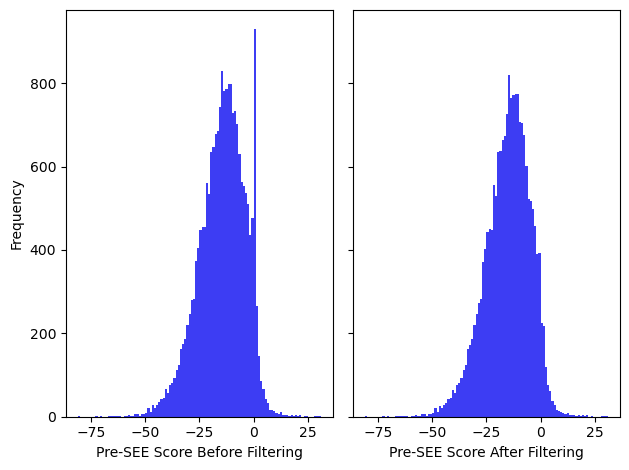

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
delta_bins = np.arange(min(df['pre_delta_sum']), max(df['pre_delta_sum']), 1)
filter_delta_bins = np.arange(min(df_processed['pre_delta_sum']), max(df_processed['pre_delta_sum']), 1)
ax1.hist(df['pre_delta_sum'], bins=delta_bins, color="#3d3df3")
ax2.hist(df_processed['pre_delta_sum'], bins=filter_delta_bins, color="#3d3df3")
ax1.set_xlabel("Pre-SEE Score Before Filtering")
ax2.set_xlabel("Pre-SEE Score After Filtering")
ax1.set_ylabel("Frequency")
plt.tight_layout()


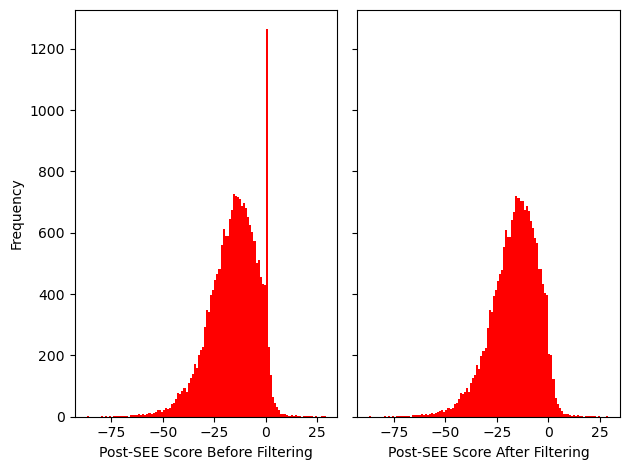

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
delta_bins = np.arange(min(df['post_delta_sum']), max(df['post_delta_sum']), 1)
filter_delta_bins = np.arange(min(df_processed['post_delta_sum']), max(df_processed['post_delta_sum']), 1)
ax1.hist(df['post_delta_sum'], bins=delta_bins, color="red")
ax2.hist(df_processed['post_delta_sum'], bins=filter_delta_bins, color="red")
ax1.set_xlabel("Post-SEE Score Before Filtering")
ax2.set_xlabel("Post-SEE Score After Filtering")
ax1.set_ylabel("Frequency")
plt.tight_layout()